In [7]:
#import all required packages
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, vstack, Table
from astropy.coordinates import SkyCoord, search_around_sky, Angle

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [8]:
#new functions needed for this notebook
from astropy.coordinates.matching import _get_cartesian_kdtree

from regions import read_ds9, write_ds9, CircleSkyRegion


In [9]:
#import configuration for selected file
from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

from config import *

In [10]:
#change directory to where data is
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

In [11]:
#pick a field to start with so we can get the table structure. 
#The files for the field cannot be empty or an error message will display
startfield=FieldA.name

if os.path.exists(startfield+'_'+str(wavelength)+'um_daoCat_psf.fits'):
    mastercatDAO=Table.read(startfield+'_'+str(wavelength)+'um_daoCat_psf.fits')
    
    #fix for issue with combining tables with objects as columns
    mastercatDAO['RA(J2000)']=mastercatDAO['sky_centroid'].ra
    mastercatDAO['DEC(J2000)']=mastercatDAO['sky_centroid'].dec
    mastercatDAO.remove_column('sky_centroid')

else:
    print('Error... Must pick another file to start with')
    
if os.path.exists(startfield+'_'+str(wavelength)+'um_segCat_psf.fits'):
    mastercatSEG=Table.read(FieldA.name+'_'+str(wavelength)+'um_segCat_psf.fits')
    
    #fix for issue with combining tables with objects as columns
    mastercatSEG['RA(J2000)']=mastercatSEG['sky_centroid'].ra
    mastercatSEG['DEC(J2000)']=mastercatSEG['sky_centroid'].dec
    mastercatSEG.remove_column('sky_centroid')
    
else:
    print('Error... Must pick another file to start with')

    
if os.path.exists(startfield+'_'+str(wavelength)+'um_usrCat_psf.fits'):
    mastercatUSR=Table.read(FieldA.name+'_'+str(wavelength)+'um_usrCat_psf.fits')
    
    #fix for issue with combining tables with objects as columns
    mastercatUSR['RA(J2000)']=mastercatUSR['sky_centroid'].ra
    mastercatUSR['DEC(J2000)']=mastercatUSR['sky_centroid'].dec
    mastercatUSR.remove_column('sky_centroid')
    
else:
    print('Error... Must pick another file to start with')

In [12]:
#loop through all the saved photometry tables for individual fields and append them together
for info in field._registry:
    filename=info.filename
    name=info.name
    
    #print('\nLoading in photometry data from field: ', name)
    
    if name is not startfield:
        
        if os.path.exists(name+'_'+str(wavelength)+'um_daoCat_psf.fits'):
            #newtab1=ascii.read(name+'_'+str(wavelength)+'um_daoCat_psf.dat')
            newtab1=Table.read(name+'_'+str(wavelength)+'um_daoCat_psf.fits')
            
            #fix for issue with combining tables with objects as columns
            newtab1['RA(J2000)']=newtab1['sky_centroid'].ra
            newtab1['DEC(J2000)']=newtab1['sky_centroid'].dec
            newtab1.remove_column('sky_centroid')
            
            #combine tables
            mastercatDAO=vstack([mastercatDAO,newtab1])
            
        if os.path.exists(name+'_'+str(wavelength)+'um_segCat_psf.fits'):
            #newtab2=ascii.read(name+'_'+str(wavelength)+'um_segCat_psf.dat')
            newtab2=Table.read(name+'_'+str(wavelength)+'um_segCat_psf.fits')
            
            #fix for issue with combining tables with objects as columns
            newtab2['RA(J2000)']=newtab2['sky_centroid'].ra
            newtab2['DEC(J2000)']=newtab2['sky_centroid'].dec
            newtab2.remove_column('sky_centroid')
            
            #combine tables and re-add "sky_centroid" column
            mastercatSEG=vstack([mastercatSEG,newtab2])
            
        if os.path.exists(name+'_'+str(wavelength)+'um_usrCat_psf.fits'):
            #newtab2=ascii.read(name+'_'+str(wavelength)+'um_segCat_psf.dat')
            newtab3=Table.read(name+'_'+str(wavelength)+'um_usrCat_psf.fits')
            
            #fix for issue with combining tables with objects as columns
            newtab3['RA(J2000)']=newtab3['sky_centroid'].ra
            newtab3['DEC(J2000)']=newtab3['sky_centroid'].dec
            newtab3.remove_column('sky_centroid')
            
            #combine tables and re-add "sky_centroid" column
            mastercatUSR=vstack([mastercatUSR,newtab3])

#re-add "sky_centroid" column 
mastercatDAO['sky_centroid']=SkyCoord(mastercatDAO['RA(J2000)'],mastercatDAO['DEC(J2000)'],unit=u.deg)
mastercatSEG['sky_centroid']=SkyCoord(mastercatSEG['RA(J2000)'],mastercatSEG['DEC(J2000)'],unit=u.deg)
mastercatUSR['sky_centroid']=SkyCoord(mastercatUSR['RA(J2000)'],mastercatUSR['DEC(J2000)'],unit=u.deg)


#print the table sizes to get source counts
print('Raw number of seg map sources: ', len(mastercatSEG))
print('Raw number of daofind sources: ', len(mastercatDAO))
print('Raw number of user defined sources: ', len(mastercatUSR))

Raw number of seg map sources:  684
Raw number of daofind sources:  520
Raw number of user defined sources:  5


In [13]:
#add 'master' ids in the combined tables
mastercatSEG['Master_id']=np.linspace(1,len(mastercatSEG),len(mastercatSEG),dtype=np.int)
mastercatDAO['Master_id']=np.linspace(1,len(mastercatDAO),len(mastercatDAO),dtype=np.int)
mastercatUSR['Master_id']=np.linspace(1,len(mastercatUSR),len(mastercatUSR),dtype=np.int)

C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_26932/654341621.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mastercatSEG['Master_id']=np.linspace(1,len(mastercatSEG),len(mastercatSEG),dtype=np.int)
C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_26932/654341621.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

In [17]:
#print the seg table
mastercatSEG

id,xcentroid,ycentroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,ann_bkg_std,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,texp_med,texp_mean,aper_snr_6as,pixApArea,pixAnnArea,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,"Cutouts [11,11]","VarCutout [11,11]","Residuals [11,11]",PSF_FLUX,PSF_FLUX_ERR,PSF_XFWHM,PSF_XFWHM_ERR,PSF_YFWHM,PSF_yFWHM_ERR,PSF_FitAmp,PSF_FitAmpERR,PSF_XFIT,PSF_XFIT_ERR,PSF_YFIT,PSF_YFIT_ERR,PSF_THETA,PSF_THETA_ERR,PSF_DCOFF,PSF_DCO_ERR,PSF_QFLAG,RA(J2000),DEC(J2000),sky_centroid,Master_id
,,,,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,"deg,deg",
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes9,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int32
1,185.7,45.24,-0.000492,-0.0009628,-0.09339,97,2.623,2.101,2.52,0.1455,-0.00714,0.2265,0.5988,0.1991,1.249,5.595,9.336,0.2545,2.233,5.611,0.1066,-0.0009562,-0.0008674,0.0002639,17.19,4.727802189985376,0.0889436469390749,5.078397056561654,0.09530191284760216,5.403989457335045,0.10166382165896459,5.702069565028304,0.10802701385333587,5.9813474800023645,0.11439406261763937,6.229955762680744,0.12074576358480896,6.466638925954159,0.1270826634684587,6.6939587504081715,0.133410243788148,6.904545802511391,0.13973272916862717,7.100617264536754,0.14603618231173973,7.286179676309249,0.1523317147066936,8.815050949787596,0.2528423765132685,-0.0019191047176718712,-0.002616746775841126,0.0060324662998497095,7.654163550024272,0.1523317147066936,418.6301094515935,335.6446244504379,135.373503873214,191.74767813683215,830.906605259606,4.853018924791183,5.222140757231584,5.567537845652833,5.886700362777682,6.1883384089670646,6.460584544644499,6.722183282700702,6.975696403721236,7.213754474174709,7.438574676334057,7.654163550024272,9.83722837677377,86.3269840205305,92.9185017476574,99.0611226133018,104.70732778781321,110.02168799120246,114.77912772478543,119.33411332321741,123.73498058907201,127.84172316726564,131.69598491629915,135.37350

In [18]:
#print the dao table
mastercatDAO

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,ann_bkg_std,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,texp_med,texp_mean,aper_snr_6as,pixApArea,pixAnnArea,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,"Cutouts [11,11]","Residuals [11,11]","VarCutout [11,11]",PSF_FLUX,PSF_FLUX_ERR,PSF_XFWHM,PSF_XFWHM_ERR,PSF_YFWHM,PSF_yFWHM_ERR,PSF_FitAmp,PSF_FitAmpERR,PSF_XFIT,PSF_XFIT_ERR,PSF_YFIT,PSF_YFIT_ERR,PSF_THETA,PSF_THETA_ERR,PSF_DCOFF,PSF_DCO_ERR,PSF_QFLAG,RA(J2000),DEC(J2000),sky_centroid,Master_id
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,"deg,deg",
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes9,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int32
1,186.1,44.84,0.4259,-0.1241,-0.3096,25,0,0.1282,2.386,-0.9442,4.751258750331228,0.09053983866863628,5.090156319905871,0.09694415014020512,5.408331327314582,0.10332526047522657,5.713916000372706,0.10969161094417929,5.9894445208131115,0.11604385944811185,6.239870290827739,0.12240152468892929,6.473274680415571,0.12875286156267501,6.6936962954574915,0.13509554643237615,6.912852709471008,0.1414293911958265,7.1281826803860575,0.14775584055002705,7.332079406153911,0.1540695392645545,8.906922389086096,0.2546493475894133,-0.0018642893992364407,-0.002792585354557674,0.006060627136400387,7.689552570848872,0.1540695392645545,363.0956726074219,324.1836220894223,135.99895216196947,191.74767868195312,830.9066076217965,4.872898924428819,5.22979427486484,5.567208289401231,5.893273195853337,6.190523175954027,6.46391163189524,6.72151993367596,6.96738668717707,7.213229465916079,7.456487027822922,7.689552570848872,9.899903402127654,86.67746550270837,93.03582443880437,99.02553701439791,104.80043151730695,110.02971571215517,114.80665468942489,119.28381625493022,123.53737655149578,127.78944324667988,131.99148300743917,135.99895216196947,170.84236420028708,170.84236420028708,C7FieldA,25,0.017665129789300116 .. 0.007318155115897937,0.0005164360070454774 .. -0.006799474881214525,0.00016151118325069547 .. 8.310005796374753e-05,16.653873816891352,0.13061674394341488,6.682053238304444,0.0014116890321146933,5.830995338903299,0.0012879950272644879,0.12187781055921855,1.6592362075378848e-05,0.20763865751415178,0.0003362950253886589,0.31402507033701266,0.00029307775717923087,-0.22057416745665864,0.0006285102887411889,0.011269888123018393,1.5

In [19]:
#print the dao table
mastercatUSR

id,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,ann_bkg_std,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,texp_med,texp_mean,aper_snr_6as,pixApArea,pixAnnArea,xcentroid,ycentroid,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,"Cutouts [11,11]","Residuals [11,11]","VarCutout [11,11]",PSF_FLUX,PSF_FLUX_ERR,PSF_XFWHM,PSF_XFWHM_ERR,PSF_YFWHM,PSF_yFWHM_ERR,PSF_FitAmp,PSF_FitAmpERR,PSF_XFIT,PSF_XFIT_ERR,PSF_YFIT,PSF_YFIT_ERR,PSF_THETA,PSF_THETA_ERR,PSF_DCOFF,PSF_DCO_ERR,PSF_QFLAG,RA(J2000),DEC(J2000),sky_centroid,Master_id
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,"deg,deg",
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes8,int32,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int32
1,2.819338654003529,0.07187902993670281,3.123348430374425,0.07701169257578497,3.4315348257220486,0.08214502293065044,3.7468030578400757,0.08727851367999513,4.071137856957016,0.09241076355641499,4.401203808794293,0.09754196058781195,4.731528857258646,0.10267230752631173,5.055993653904768,0.1078030648155743,5.381695685556618,0.11293374315995774,5.716854908552602,0.11806424809309506,6.070547748056062,0.12319345157365523,13.023536931216714,0.20520032845373332,0.014730249997228384,0.015721409027024152,0.010567867530921296,3.2460572621021226,0.12319345157365523,477.7574157714844,477.24871675718356,38.73331696699132,191.74762726263234,830.9063848047402,91.47078083850195,220.91457305154063,1.8582273080886467,2.020031834298668,2.176205720853631,2.3296541855472137,2.482361958607925,2.6309936257571884,2.7700771309017442,2.8934931255962826,3.0083390966647676,3.1228350004455985,3.2460572621021226,5.177730025789105,21.931041989936848,24.043511512274563,26.05159787488151,28.009097973537383,29.95314545104883,31.82034729371514,33.50666800639848,34.89619046134989,36.12408607156001,37.34617147011127,38.73331696699132,60.204781470953066,60.204781470953066,C7FieldA,25,0.0006892135586428379 .. 0.004659327001268972,-0.003765233773549647 .. -0.005115768842880848,7.89204e-05 .. 7.935444e-05,17.085827395659546,0.18053586827060975,7.334507292466408,0.0029546775574769693,5.591433587861569,0.0023637746778806994,0.043232583871430974,1.1748065428529607e-05,-0.7377505241855635,0.0006878898672845745,-0.7820816890688782,0.0006488528677050572,-0.6896755927342677,0.0006737338904398525,0.003074807328145098,1.02912300113419e-05,0.0,266.34856375,-29.040334444444447,"266.34856375,-29.040334444444447",1
2,4.78720896793273,0.09177089972044501,5.128557432733311,0.0981854513

In [20]:
#write 'master' catalogs to fits
mastercatSEG.write('masterCatSeg_FromFields_'+str(wavelength)+'um.fits',overwrite=True)
mastercatDAO.write('masterCatDao_FromFields_'+str(wavelength)+'um.fits',overwrite=True)
mastercatUSR.write('masterCatUser_FromFields_'+str(wavelength)+'um.fits',overwrite=True)

In [21]:
scseg=mastercatSEG['sky_centroid']
scdao=mastercatDAO['sky_centroid']
scusr=mastercatUSR['sky_centroid']

In [22]:
def makeDS9file(savename, table, radius, color='green', labelon=False,label='ColumnName'):
    scs=table['sky_centroid']
    
    decimals = 1 # number of decimal places to display with labels
    
    #loop through and create region instances for each source
    regions=[]
    for i in range(0,len(scs)):
        region = CircleSkyRegion(scs[i], radius)
        regions.append(region)
            #write out region file
    write_ds9(regions, savename)
    
    hld=""
    with open(savename, 'r+') as f:
        lineno=0
        for line in f:
            if lineno<len(table):
                if label:
                    text=line.replace(r')', r') # color='+color+' text={'+str(np.round(table[label][lineno-2],decimals))+'}')
                else:
                    text=line.replace(r')', r') # color='+color)
                hld=hld+text
                lineno=lineno+1
        f.seek(0)
        f.write(hld)
        f.truncate()

In [23]:
#write out save ds9 region files

#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('mastercatSEG_'+str(wavelength)+'_labelID.reg', mastercatSEG, r, color='cyan', labelon=True, label="Master_id")
makeDS9file('mastercatDAO_'+str(wavelength)+'_labelID.reg', mastercatDAO, r, color='yellow', labelon=True, label="Master_id")
makeDS9file('mastercatUser_'+str(wavelength)+'_labelID.reg', mastercatUSR, r, color='red', labelon=True, label="Master_id")

makeDS9file('mastercatSEG_'+str(wavelength)+'_label6asSNR.reg', mastercatSEG, r, color='cyan', labelon=True, label="aper_snr_6as")
makeDS9file('mastercatDAO_'+str(wavelength)+'_label6asSNR.reg', mastercatDAO, r, color='yellow', labelon=True, label="aper_snr_6as")
makeDS9file('mastercatUser_'+str(wavelength)+'_label6asSNR.reg', mastercatUSR, r, color='red', labelon=True, label="aper_snr_6as")


In [24]:
#source coords should be skycoord objects, sep should be an angular quantity e.g., 4*u.arcsec
def remove_duplicates(mastercat, sep):
	sourcecoords=mastercat['sky_centroid']

	#create KD Tree
	kdt=_get_cartesian_kdtree(sourcecoords)
    
	#search radius
	r = (2 * np.sin(Angle(sep) / 2.0)).value #search radius
    
	#initialize counter
	counter=0
    
	#create array to hold matches
	matchstore=np.zeros(len(mastercat),dtype=np.int)
    
	#loop through and find all matching sources within crossmatch radius
	for i, matches in enumerate(kdt.query_ball_tree(kdt,r)):
		if len(matches)>1:
			counter+=1
			
			for match in matches:
				if match!=matches[(match+1)%len(matches)]:
					matchstore[match]=matches[(match+1)%len(matches)]+1
				else:
					matchstore[match]=matches[(match+2)%len(matches)]+1

	#store possible crossmatches
	mastercat['selfXmatch']=matchstore
	print('number of likely duplicates: ', counter)
    
	#create keep and remove lists
	keep=[]
	remove=[]
    
	#loop through and mark sources to keep and remove based on which has the greater aperture photometry snr
	for row in mastercat:
		if row['selfXmatch']>0:
			#print(row['Master_id'])
			idx1 = row['Master_id']
			idx2 = row['selfXmatch']
			
			row1=mastercat[mastercat['Master_id']==idx1]
			row2=mastercat[mastercat['Master_id']==idx2]
			
			snr1=row1['aper_snr_max'].data[0]
			snr2=row2['aper_snr_max'].data[0]
			           
			if snr1>snr2:
				keep.append(idx1)
				remove.append(idx2)
			else:
				keep.append(idx2)
				remove.append(idx1)

	#remove duplicates in lists
	keep=list(set(keep))
	remove=list(set(remove))
    
	#remove duplicates in table
	removeIdx=np.array(remove)-1 #fix zero/one initialization issue
	mastercat.remove_rows(removeIdx)
	
	return mastercat

In [25]:
#Now lets look at possible duplications that may exist because of overlapping data coverage

print('Number of sources with duplicates included', len(mastercatSEG))

mastercatSEG=remove_duplicates(mastercatSEG, 4.0*u.arcsec)

print('Number of sources with duplicates removed', len(mastercatSEG))



Number of sources with duplicates included 684
number of likely duplicates:  218


C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_26932/3055322738.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(mastercat),dtype=np.int)


Number of sources with duplicates removed 573


In [26]:
#repeat for dao 
print('Number of sources with duplicates included', len(mastercatDAO))

mastercatDAO=remove_duplicates(mastercatDAO, 4.0*u.arcsec)

print('Number of sources with duplicates removed', len(mastercatDAO))

Number of sources with duplicates included 520
number of likely duplicates:  104


C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_26932/3055322738.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(mastercat),dtype=np.int)


Number of sources with duplicates removed 465


In [27]:
#write 'master' catalogs to fits
mastercatSEG.write('masterCatSeg_FromFields_noDuplicates_'+str(wavelength)+'um.fits',overwrite=True)
mastercatDAO.write('masterCatDao_FromFields_noDuplicates_'+str(wavelength)+'um.fits',overwrite=True)


In [28]:
#write out save ds9 region files
makeDS9file('mastercatSEG_noDuplicates_'+str(wavelength)+'_labelID.reg', mastercatSEG, r, color='cyan', labelon=True, label="Master_id")
makeDS9file('mastercatDAO_noDuplicates_'+str(wavelength)+'_labelID.reg', mastercatDAO, r, color='yellow', labelon=True, label="Master_id")

#makeDS9file('mastercatSEG_'+str(wavelength)+'_labelMaxSNR.reg', mastercatSEG, r, color='cyan', labelon=True, label="aper_snr_max")
#makeDS9file('mastercatDAO_'+str(wavelength)+'_labelMaxSNR.reg', mastercatDAO, r, color='yellow', labelon=True, label="aper_snr_max")


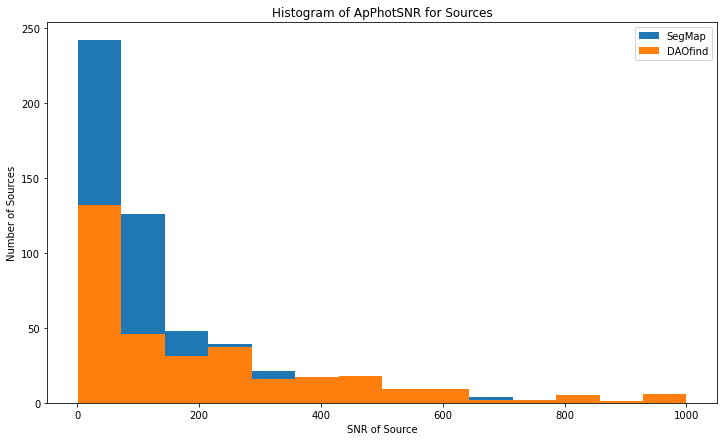

In [29]:
#now lets look at SNR distrobution
binlist=np.linspace(1,1000,15)

plt.figure(figsize=(12,7))
plt.title('Histogram of ApPhotSNR for Sources')
plt.hist(mastercatSEG['aper_snr_6as'],bins=binlist,label='SegMap')
plt.hist(mastercatDAO['aper_snr_6as'],bins=binlist,label='DAOfind')
plt.legend()
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


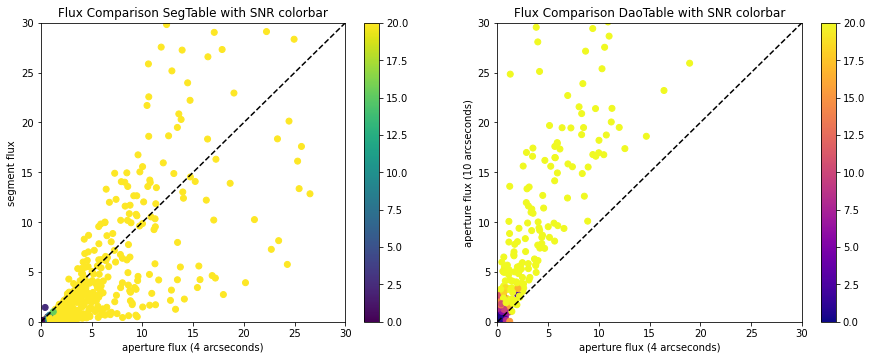

In [30]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison SegTable with SNR colorbar')
p1=ax1.scatter(mastercatSEG['aper_sum_bkgsub_4.0as'],mastercatSEG['segment_flux'],c=mastercatSEG['aper_snr_max'], cmap='viridis',vmin=0,vmax=20)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (4 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)


ax2.set_title('Flux Comparison DaoTable with SNR colorbar')
p2=ax2.scatter(mastercatDAO['aper_sum_bkgsub_4.0as'],mastercatDAO['aper_sum_bkgsub_10as'],c=mastercatDAO['aper_snr_max'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (4 arcseconds)')
ax2.set_ylabel('aperture flux (10 arcseconds)')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)

plt.show()

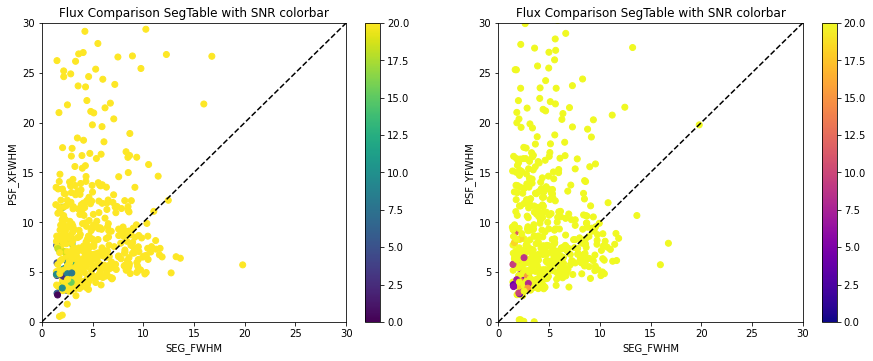

In [31]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison SegTable with SNR colorbar')
p1=ax1.scatter(mastercatSEG['fwhm'],mastercatSEG['PSF_XFWHM'],c=mastercatSEG['aper_snr_max'], cmap='viridis',vmin=0,vmax=20)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('SEG_FWHM')
ax1.set_ylabel('PSF_XFWHM')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)


ax2.set_title('Flux Comparison SegTable with SNR colorbar')
p2=ax2.scatter(mastercatSEG['fwhm'],mastercatSEG['PSF_YFWHM'],c=mastercatSEG['aper_snr_max'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('SEG_FWHM')
ax2.set_ylabel('PSF_YFWHM')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)

plt.show()

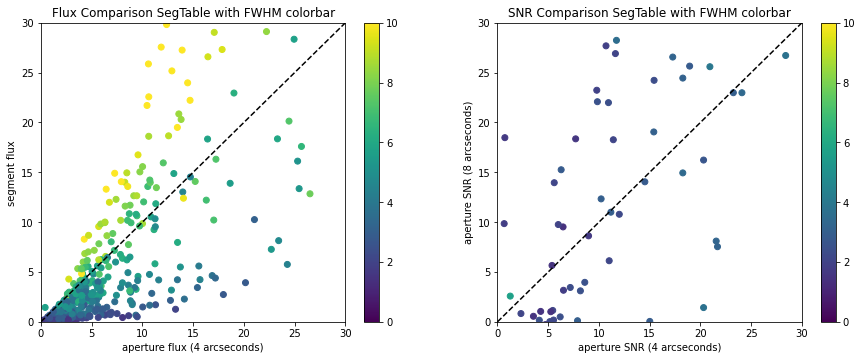

In [32]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison SegTable with FWHM colorbar')
p1=ax1.scatter(mastercatSEG['aper_sum_bkgsub_4.0as'],mastercatSEG['segment_flux'],c=mastercatSEG['fwhm'], cmap='viridis',vmin=0,vmax=10)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (4 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)


ax2.set_title('SNR Comparison SegTable with FWHM colorbar')
p2=ax2.scatter(mastercatSEG['aper_snr_4.0as'],mastercatSEG['aper_snr_10as'],c=mastercatSEG['fwhm'], cmap='viridis',vmin=0,vmax=10)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture SNR (4 arcseconds)')
ax2.set_ylabel('aperture SNR (8 arcseconds)')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)

plt.show()

In [ ]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1) = plt.subplots(1, 1,figsize=(15,5.5))

#ax1.set_title('Flux Comparison SegTable with FWHM colorbar')
p1=ax1.scatter(mastercatSEG['PSF_XFIT'],mastercatSEG['PSF_YFIT'],c=mastercatSEG['PSF_YFIT_ERR']+mastercatSEG['PSF_XFIT_ERR'], cmap='viridis',vmin=0,vmax=0.03)
fig.colorbar(p1, ax=ax1)
#ax1.plot([0,30],[0,30],'k--')
#ax1.set_xlabel('aperture flux (4 arcseconds)')
#ax1.set_ylabel('segment flux')
ax1.set_xlim(-20,20)
ax1.set_ylim(-20,20)

plt.show()

In [ ]:
#checkids=mastercatSEG['PSF_XFIT_ERR']>0.025 or mastercatSEG['PSF_YFIT_ERR']>0.025
m1=mastercatSEG['PSF_YFIT_ERR']>0.025
m2=mastercatSEG['PSF_XFIT_ERR']>0.025

mask = [any(tup) for tup in zip(m1,m2)]

In [ ]:
hierr=mastercatSEG[mask]
hierr

In [ ]:
#look through...

i=2

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True,figsize=(13,10))


norm1 = simple_norm(hierr['Cutouts'][(0+i*9)%37], 'sqrt', percent=99)
norm2 = simple_norm(hierr['Cutouts'][(1+i*9)%37], 'sqrt', percent=99)
norm3 = simple_norm(hierr['Cutouts'][(2+i*9)%37], 'sqrt', percent=99)
norm4 = simple_norm(hierr['Cutouts'][(3+i*9)%37], 'sqrt', percent=99)
norm5 = simple_norm(hierr['Cutouts'][(4+i*9)%37], 'sqrt', percent=99)
norm6 = simple_norm(hierr['Cutouts'][(5+i*9)%37], 'sqrt', percent=99)
norm7 = simple_norm(hierr['Cutouts'][(6+i*9)%37], 'sqrt', percent=99)
norm8 = simple_norm(hierr['Cutouts'][(7+i*9)%37], 'sqrt', percent=99)
norm9 = simple_norm(hierr['Cutouts'][(8+i*9)%37], 'sqrt', percent=99)



p1=axs[0, 0].imshow(hierr['Cutouts'][(0+i*9)%37],cmap=plt.cm.jet, origin='lower',norm=norm1)
p2=axs[0, 1].imshow(hierr['Cutouts'][(1+i*9)%37],cmap=plt.cm.jet, origin='lower',norm=norm2)
p3=axs[0, 2].imshow(hierr['Cutouts'][(2+i*9)%37],cmap=plt.cm.jet, origin='lower',norm=norm3)
p4=axs[1, 0].imshow(hierr['Cutouts'][(3+i*9)%37],cmap=plt.cm.jet, origin='lower',norm=norm4)
p5=axs[1, 1].imshow(hierr['Cutouts'][(4+i*9)%37],cmap=plt.cm.jet, origin='lower',norm=norm5)
p6=axs[1, 2].imshow(hierr['Cutouts'][(5+i*9)%37],cmap=plt.cm.jet, origin='lower',norm=norm6)
p7=axs[2, 0].imshow(hierr['Cutouts'][(6+i*9)%37],cmap=plt.cm.jet, origin='lower',norm=norm7)
p8=axs[2, 1].imshow(hierr['Cutouts'][(7+i*9)%37],cmap=plt.cm.jet, origin='lower',norm=norm8)
p9=axs[2, 2].imshow(hierr['Cutouts'][(8+i*9)%37],cmap=plt.cm.jet, origin='lower',norm=norm9)


divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='8%', pad=0.18)
fig.colorbar(p1, cax=cax, orientation='vertical')
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='8%', pad=0.18)
fig.colorbar(p2, cax=cax, orientation='vertical');
divider = make_axes_locatable(axs[0, 2])
cax = divider.append_axes('right', size='8%', pad=0.18)
fig.colorbar(p3, cax=cax, orientation='vertical');
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='8%', pad=0.18)
fig.colorbar(p4, cax=cax, orientation='vertical')
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='8%', pad=0.18)
fig.colorbar(p5, cax=cax, orientation='vertical');
divider = make_axes_locatable(axs[1, 2])
cax = divider.append_axes('right', size='8%', pad=0.18)
fig.colorbar(p6, cax=cax, orientation='vertical');
divider = make_axes_locatable(axs[2, 0])
cax = divider.append_axes('right', size='8%', pad=0.18)
fig.colorbar(p7, cax=cax, orientation='vertical')
divider = make_axes_locatable(axs[2, 1])
cax = divider.append_axes('right', size='8%', pad=0.18)
fig.colorbar(p8, cax=cax, orientation='vertical');
divider = make_axes_locatable(axs[2, 2])
cax = divider.append_axes('right', size='8%', pad=0.18)
fig.colorbar(p9, cax=cax, orientation='vertical');


axs[0,0].set_title(hierr['Master_id'][(0+i*9)%37])
axs[0,1].set_title(hierr['Master_id'][(1+i*9)%37])
axs[0,2].set_title(hierr['Master_id'][(2+i*9)%37])
axs[1,0].set_title(hierr['Master_id'][(3+i*9)%37])
axs[1,1].set_title(hierr['Master_id'][(4+i*9)%37])
axs[1,2].set_title(hierr['Master_id'][(5+i*9)%37])
axs[2,0].set_title(hierr['Master_id'][(6+i*9)%37])
axs[2,1].set_title(hierr['Master_id'][(7+i*9)%37])
axs[2,2].set_title(hierr['Master_id'][(8+i*9)%37])

fig.tight_layout(pad=0.5)

plt.show()



In [ ]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('DaoTable sharpness, roundness1 comparison SNR cbar')
p1=ax1.scatter(mastercatDAO['sharpness'],mastercatDAO['roundness1'],c=mastercatDAO['aper_snr_max'], cmap='plasma',vmin=0,vmax=10)
fig.colorbar(p1, ax=ax1)
#ax1.plot([0,3],[0,3],'k--')
ax1.set_xlabel('sharpness')
ax1.set_ylabel('roundness1')
#ax1.set_xlim(0,30)
#ax1.set_ylim(0,30)


ax2.set_title('DaoTable roundness1, roundness2 comparison SNR cbar')
p2=ax2.scatter(mastercatDAO['roundness2'],mastercatDAO['roundness1'],c=mastercatDAO['aper_snr_max'], cmap='plasma',vmin=0,vmax=10)
fig.colorbar(p2, ax=ax2)
#ax2.plot([0,3],[0,3],'k--')
ax2.set_xlabel('roundness2')
ax2.set_ylabel('roundness1')
#ax2.set_xlim(0,30)
#ax2.set_ylim(0,30)

plt.show()

In [146]:
#lets just do a simple SNR cuts for both tables
snrcutSEG=mastercatSEG['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
snrcutDAO=mastercatDAO['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0

mctseg=mastercatSEG[snrcutSEG] #apply snr cut
mctdao=mastercatDAO[snrcutDAO] #apply snr cut

In [147]:
mctseg

id,xcentroid,ycentroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,"Cutouts [11,11]","VarCutout [11,11]","Residuals [11,11]",PSF_FLUX,PSF_FLUX_ERR,PSF_XFWHM,PSF_XFWHM_ERR,PSF_YFWHM,PSF_yFWHM_ERR,PSF_FitAmp,PSF_FitAmpERR,PSF_XFIT,PSF_XFIT_ERR,PSF_YFIT,PSF_YFIT_ERR,PSF_THETA,PSF_THETA_ERR,PSF_DCOFF,PSF_DCO_ERR,PSF_QFLAG,RA(J2000),DEC(J2000),sky_centroid,Master_id,selfXmatch
,,,,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,"deg,deg",,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes9,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int32,int32
1,185.7,45.31,-0.0006776,-0.001014,-0.1075,106,2.733,2.183,3.04,0.1341,-0.008054,0.2097,0.6019,0.2014,1.252,5.824,9.37,0.2558,2.16,5.801,0.1108,-0.001011,-0.0008954,0.0003291,17.43,4.715535430639904,0.08865774134808732,5.0686470250236475,0.09501235308220325,5.395080772483453,0.1013715024171086,5.691024309997666,0.10772813183603328,5.971807309454512,0.1140908024895709,6.222306252152798,0.12044095827487528,6.459467791823525,0.12677559187389958,6.68628798824439,0.13310152585970775,6.897801361668851,0.1394228897473043,7.0931339094736625,0.1457259218288002,7.278939295482473,0.15202044947990104,8.807308624113137,0.25252809971349394,-0.0019341523293405771,-0.0026085702528510315,7.649808353300112,0.15202044947990104,0.0,191.747595156624,830.9062456787041,17.68525123822646,4.841733929480628,5.213517750733662,5.559911464846848,5.87710270879853,6.180421154476933,6.454743283180866,6.717015748641329,6.9702346106360205,7.209434389418393,7.433741082365209,7.649808353300112,9.837500451384356,15.657677762508598,16.19939663924194,16.630603527756595,16.951510656593925,17.214344472064724,17.38437347196354,17.513847139813677,17.612710488377914,17.67047859705882,17.688810359087032,17.68525123822646,15.2817195934517,17.688810359087032,C7FieldA,25,0.018119730

In [148]:
mctdao

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,"Cutouts [11,11]","Residuals [11,11]","VarCutout [11,11]",PSF_FLUX,PSF_FLUX_ERR,PSF_XFWHM,PSF_XFWHM_ERR,PSF_YFWHM,PSF_yFWHM_ERR,PSF_FitAmp,PSF_FitAmpERR,PSF_XFIT,PSF_XFIT_ERR,PSF_YFIT,PSF_YFIT_ERR,PSF_THETA,PSF_THETA_ERR,PSF_DCOFF,PSF_DCO_ERR,PSF_QFLAG,RA(J2000),DEC(J2000),sky_centroid,Master_id,selfXmatch
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,"deg,deg",,
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes9,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int32,int32
1,186.1,44.84,0.426,-0.1258,-0.3117,25,0,0.128,2.362,-0.9331,4.752020089077418,0.09052195154188267,5.090639266993264,0.09692564013702797,5.40871011741913,0.10330646250555055,5.714643834291809,0.10967302061234388,5.989836251348512,0.11602536641496866,6.2401960159978,0.12238304453581568,6.4736204746805805,0.12873420628691057,6.694103192761603,0.1350767354729213,6.913012271154023,0.14141038342301399,7.128153529634116,0.1477366971558415,7.331729616892913,0.15404986493205325,8.90587702105805,0.25462859468388244,-0.0018642893992364407,-0.0027903873453774394,7.689202625872488,0.15404986493205325,0.0,191.747595156624,830.9062456787041,17.658846419244217,4.873660210188524,5.23027716112591,5.567587010298941,5.894000951644408,6.1909148188995236,6.464237259472846,6.721865619805285,6.9677934652615905,7.213388896754916,7.456457734061538,7.689202625872488,9.89885760155687,15.59778952293987,16.090271939313435,16.49686207629802,16.84883936926575,17.099211755160283,17.271252440387904,17.392654019370184,17.47733892721283,17.555485949339918,17.621706708874548,17.658846419244217,15.313476865561741,17.658846419244217,C7FieldA,25,0.01811973079480097 .. 0.007354784343325903,0.0008748032015483444 .. -0.006780242595264919,0.00016151118325069547 .. 8.310005796374753e-05,16.671454345749655,0.13093308898554085,6.6895163559982995,0.0014201686625048002,5.836793668320222,0.0012954857228915347,0.12190329926132323,1.6676141033202272e-05,0.21155666738197443,0.00033772488449017914,0.3182001757143613,0.000294599662534113,-0.22903808023511324,0.0006307551778822764,0.01125646769828235,1.548274069000533e-05,0.0,266.3254710093352,-29.077892912935287,"266.325471009335

In [153]:
#write out ds9 files
makeDS9file('mastercatSEG_nD_SNRcut3_'+str(wavelength)+'_labelID.reg', mctseg, r, color='cyan', labelon=True, label="Master_id")
makeDS9file('mastercatDAO_nD_SNRcut3_'+str(wavelength)+'_labelID.reg', mctdao, r, color='yellow', labelon=True, label="Master_id")

#makeDS9file('mastercatSEG_nD_SNRcut3_'+str(wavelength)+'_label4ApSNR.reg', mctseg, r, color='cyan', labelon=True, label="aper_snr_4.0as")
#makeDS9file('mastercatDAO_nD_SNRcut3_'+str(wavelength)+'_label4ApSNR.reg', mctdao, r, color='yellow', labelon=True, label="aper_snr_4.0as")


In [ ]:
#lets see if there are cross matches between the tables
segsources=mctseg['skycoords']
daosources=mctdao['skycoords']

idx,rdx, d2d, d3d = daosources.search_around_sky(segsources, 4*u.arcsec)

print('Number of crossmatched sources found: ', len(idx))



In [ ]:
arr1=np.zeros(len(mctseg))
arr2=np.zeros(len(mctdao))

arr1[idx]=1
arr2[rdx]=1

In [ ]:
mctseg['catXmatch']=arr1.astype(np.int)
mctdao['catXmatch']=arr2.astype(np.int)

In [ ]:
#write 'master' catalogs to files
ascii.write(mctseg,'mcSeg_FFsnr_'+str(wavelength)+'um.dat')
ascii.write(mctdao,'mcDao_FFsnr_'+str(wavelength)+'um.dat')

In [ ]:
#write out save ds9 region files

#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('mcat_segff_snrcut_'+str(wavelength)+'.reg', mctseg, r, color='cyan')
makeDS9file('mcat_daoff_snrcut_'+str(wavelength)+'.reg', mctdao, r, color='yellow')

In [ ]:
#lets save another region file for sources that pass the snr cut and are found by both daofind and segmap
cmatchcut=mctdao['catXmatch']==1
crossmatchcat=mctdao[cmatchcut]

makeDS9file('mcat_snrcut_both_'+str(wavelength)+'.reg', crossmatchcat, r, color='green')